# Main

### Prerequisites

**Imports**

In [153]:
import os
import sys
import warnings
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, LineString, MultiLineString, Point
import matplotlib.pyplot as plt

**Fix directories, define path variables**

In [154]:
# make sure notebook is ran from src
cwd = os.getcwd()
if not cwd.split('/')[-1] == 'src':
    try:
        os.chdir('src')
    except FileNotFoundError:
        print('Error: please run from src dir or project root')
        sys.exit(1)

# define paths
data_path = '../data/'
csv_path = data_path + 'csv/'
shp_path = data_path + 'shapefiles/'
plot_path = '../plots/'
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

---

### Read data

In [155]:
# these are just manhattan gdfs, with correct projection
STREETS: gpd.GeoDataFrame = gpd.read_file(shp_path + 'streets/M_streets.shp')
TRAFFIC: gpd.GeoDataFrame = gpd.read_file(shp_path + 'traffic/M_traffic.shp')
TREES: gpd.GeoDataFrame = gpd.read_file(shp_path + 'trees/M_trees.shp')

Now we create a grid.

In [156]:
# define a bounding box around Manhattan
xmin, ymin, xmax, ymax = STREETS.total_bounds
bbox = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)])

# define granularity of grid
l, w = .005, .005

# create a grid of polygons
cols = list(np.arange(xmin, xmax+w, w))
rows = list(np.arange(ymin, ymax+l, l))
polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x, y), (x, y+l), (x+w, y+l), (x+w, y), (x, y)]))

# create a gdf from the grid
GRID = gpd.GeoDataFrame({'geometry': polygons})
GRID.crs = 4326

# remove grid cells that do not intersect with any street
size_before = GRID.shape[0]
GRID = GRID[GRID.intersects(STREETS.unary_union)]
GRID = GRID.reset_index(drop=True)
print(f'Grid cells trimmed to {GRID.shape[0]} from {size_before}')

Grid cells trimmed to 393 from 1040


Now we can assign the relevant data to each grid cell.

In [157]:
# we would get a SettingWithCopyWarning, but it's not a problem
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    GRID['trees'] = GRID.geometry.apply(lambda x: TREES[TREES.geometry.within(x)].shape[0])
    GRID['traffic'] = GRID.geometry.apply(lambda x: TRAFFIC[TRAFFIC.geometry.within(x)].Avg_Vol.mean())

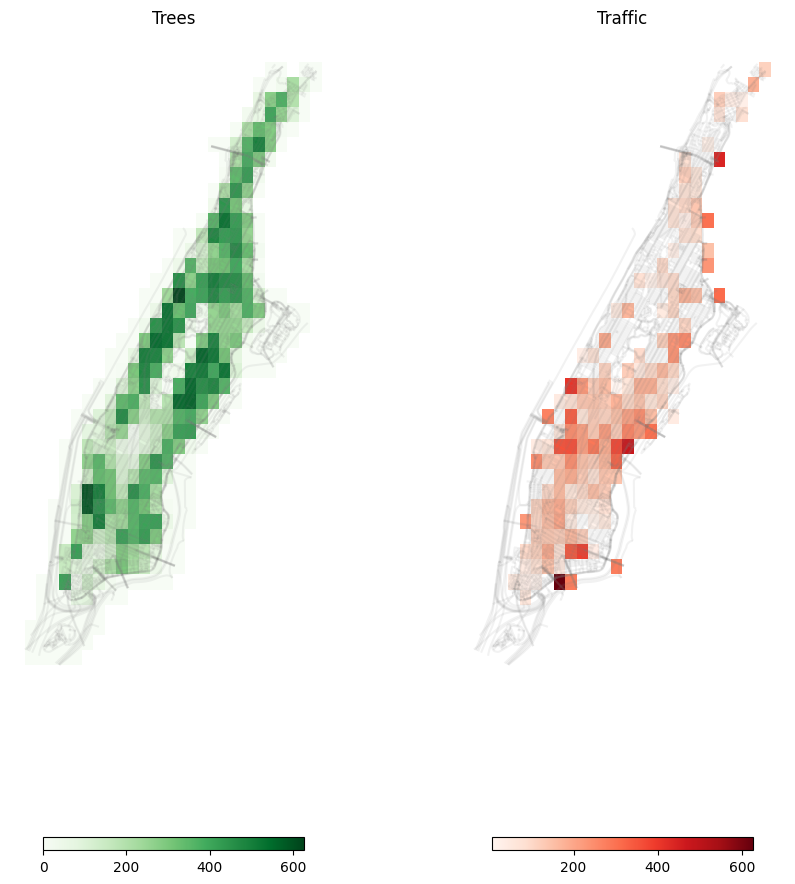

In [158]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
for ax, col, cmap in zip([ax1, ax2], ['trees', 'traffic'], ['Greens', 'Reds']):
    GRID.plot(ax=ax, column=col, cmap=cmap, legend=True, zorder=1, legend_kwds={'orientation': 'horizontal', 'shrink': 0.5})
    STREETS.plot(ax=ax, color='grey', alpha=0.1, zorder=2)
    ax.set_axis_off()
    ax.set_title(col.capitalize())
fig.tight_layout()
fig.savefig(plot_path + 'grid_raw.png', dpi=500)

We'll save the raw grid data to a shapefile again.

In [159]:
if not os.path.exists((target := shp_path + 'grid/')):
    os.mkdir(target)
GRID.to_file(target + 'M_grid.shp')

### Street lengths per grid cell

In [160]:
def haversine_4326(p1: tuple[float], p2: tuple[float]) -> float:
    """ Calculate the great circle distance in km between two points on the earth. """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [p1[0], p1[1], p2[0], p2[1]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371  # radius of earth in kilometers
    return c * r * 1000

In [161]:
# take a random grid cell
np.random.seed(42)
cell = GRID.loc[314].geometry
type(cell)

shapely.geometry.polygon.Polygon

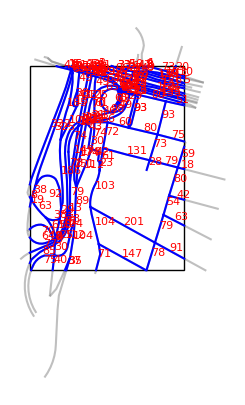

In [162]:
# see what street segments are in the cell
cell_streets = STREETS[STREETS.geometry.intersects(cell)]

# plot the cell and its street segments
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cell_streets.plot(ax=ax, color='grey', alpha=0.5, zorder=1)
# create patch object of boundary of cell (cell.exterior.coords)
ax.add_patch(plt.Polygon(cell.exterior.coords, facecolor='none', edgecolor='black', linewidth=1, zorder=2))
ax.set_axis_off()

# find all points where cell_streets intersect with cell boundary
# this is a list of tuples, where each tuple is a point
intersecting_lines: list[LineString] = [cell.intersection(line) for line in cell_streets.geometry]
# find the coordinates of the points
cents = []
distances = []
for line in intersecting_lines:
    start, end = line.coords[0], line.coords[-1]
    distance = haversine_4326(start, end)
    cents.extend([(start[0] + end[0]) / 2, (start[1] + end[1]) / 2])
    distances.append(distance)

# add intersecting lines to plot
for line in intersecting_lines:
    if not line.is_empty:
        ax.plot(*zip(*line.coords), color='blue', zorder=3)

# # add intersecting points to plot
# ax.scatter(*zip(*intersecting_points), color='red', zorder=4);

# show length of each street segment at its midpoint
for x, y, d in zip(cents[::2], cents[1::2], distances):
    ax.text(x, y, f'{d:.0f}', fontsize=8, color='red', zorder=5)


In [163]:
def get_total_street_length(cell_geometry: Polygon):
    # filter out irrelevant street segments
    streets = STREETS[STREETS.geometry.intersects(cell_geometry)]
    segments = [cell_geometry.intersection(line) for line in streets.geometry]
    total_length = 0
    for segment in segments:
        try:
            start, end = segment.coords[0], segment.coords[-1]
            total_length += haversine_4326(start, end)
        except:
            # MultiLineString has no coords, but multiple LineStrings which do
            for seg_part in segment.geoms:
                start, end = seg_part.coords[0], seg_part.coords[-1]
                total_length += np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)

    return total_length

In [164]:
GRID['street_length'] = GRID.geometry.apply(get_total_street_length)


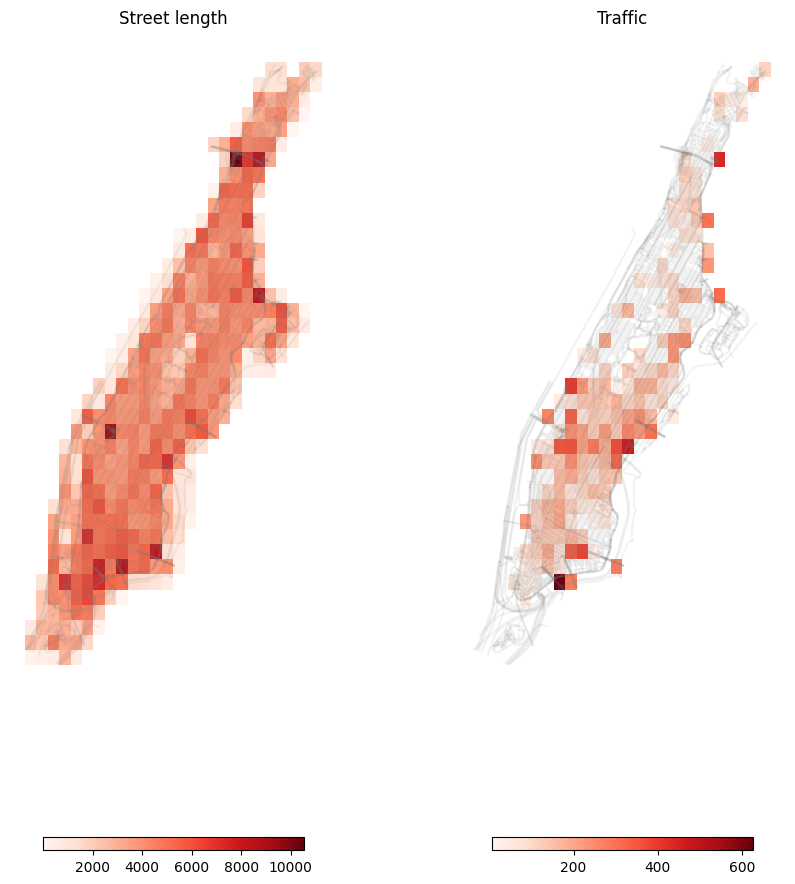

In [165]:
# plot street length vs traffic
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i, col in enumerate(['street_length', 'traffic']):
    GRID.plot(ax=ax[i], column=col, cmap='Reds', legend=True, zorder=1, legend_kwds={'orientation': 'horizontal', 'shrink': 0.5})
    STREETS.plot(ax=ax[i], color='grey', alpha=0.1, zorder=2)
    ax[i].set_axis_off()
    ax[i].set_title(col.capitalize().replace('_', ' '))
fig.tight_layout()

In [166]:
# calculate dimensions of grid cell with haversine formula
cell = GRID.sample(1).iloc[0].geometry
cell_length = haversine_4326(cell.exterior.coords[0], cell.exterior.coords[1])
cell_width = haversine_4326(cell.exterior.coords[0], cell.exterior.coords[3])

# calculate area of grid cell
cell_area = cell_length * cell_width

print(f'Cell length: {cell_length:.0f} m, cell width: {cell_width:.0f} m, cell area: {cell_area:.0f} m²')

Cell length: 556 m, cell width: 421 m, cell area: 234223 m²


In [167]:
# see what cell has highest street length
GRID.sort_values('street_length', ascending=False).head(1)

,geometry,trees,traffic,street_length
314,"POLYGON ((-73.94457 40.84469, -73.94457 40.849...",206,83.416171,10511.509982


In [168]:
# calculate average tree count divided by street length per cell (distance between trees in m)
GRID['tree_distance'] = GRID.apply(lambda row: row['street_length'] / row['trees'] if row['trees'] > 10 else np.nan, axis=1)

# take average of this
GRID['tree_distance'].median()

# convert to log scale
GRID['log_tree_distance'] = np.log(GRID['tree_distance'])

In [169]:
GRID2 = GRID.dropna(subset=['log_tree_distance'])

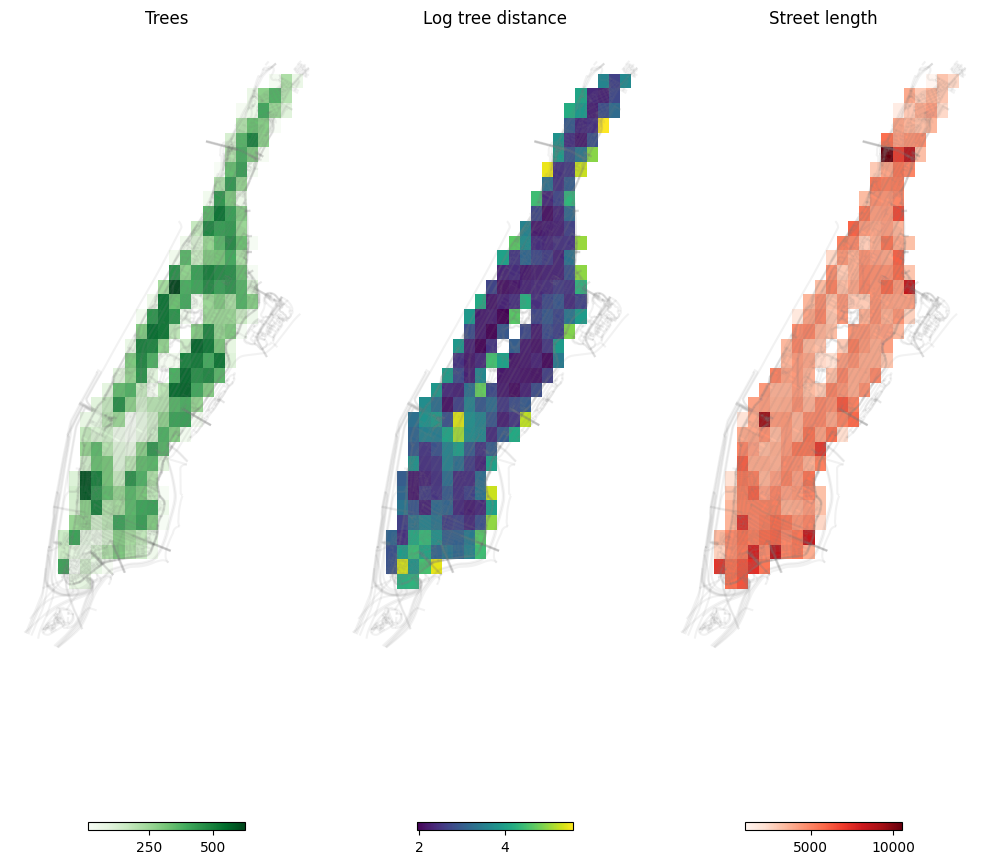

In [170]:
# plot tree density vs traffic
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
for i, (col, cmap) in enumerate(zip(['trees', 'log_tree_distance', 'street_length'], ['Greens', 'viridis', 'Reds'])):
    GRID2.plot(ax=ax[i], column=col, cmap=cmap, legend=True, zorder=1, legend_kwds={'orientation': 'horizontal', 'shrink': 0.5})
    STREETS.plot(ax=ax[i], color='grey', alpha=0.1, zorder=2)
    ax[i].set_axis_off()
    ax[i].set_title(col.capitalize().replace('_', ' '))
fig.tight_layout()

In [171]:
GRID2

,geometry,trees,traffic,street_length,tree_distance,log_tree_distance
25,"POLYGON ((-74.01957 40.70469, -74.01957 40.709...",410,48.354167,7216.672546,17.601640,2.867992
26,"POLYGON ((-74.01957 40.70969, -74.01957 40.714...",157,NaN,2692.656715,17.150680,2.842038
27,"POLYGON ((-74.01957 40.71469, -74.01957 40.719...",155,NaN,3471.504293,22.396802,3.108918
39,"POLYGON ((-74.01457 40.69969, -74.01457 40.704...",78,59.228657,5585.148816,71.604472,4.271158
40,"POLYGON ((-74.01457 40.70469, -74.01457 40.709...",26,29.385417,5571.429741,214.285759,5.367310
...,...,...,...,...,...,...
376,"POLYGON ((-73.92457 40.86969, -73.92457 40.874...",28,NaN,1018.334289,36.369082,3.593719
382,"POLYGON ((-73.91957 40.85969, -73.91957 40.864...",100,78.935019,2463.195384,24.631954,3.204045
383,"POLYGON ((-73.91957 40.86469, -73.91957 40.869...",197,28.505215,3043.768764,15.450603,2.737648
384,"POLYGON ((-73.91957 40.86969, -73.91957 40.874...",217,NaN,3100.092199,14.286139,2.659290


In [172]:
# save GRID2 to shapefile
if not os.path.exists((target := shp_path + 'grid2/')):
    os.mkdir(target)
GRID.to_file(target + 'M_grid2.shp')

/var/folders/l3/wkq2m01d4kv5rgpj8yp2twx80000gn/T/ipykernel_8890/1317271099.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  GRID.to_file(target + 'M_grid2.shp')


In [173]:
# print grid bounds
print(GRID2.total_bounds)

[-74.01957281  40.69969472 -73.90957281  40.87469472]
